In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.stats import gamma, poisson
import matplotlib as mpl
import itertools
import matplotlib.pyplot as plt
import re
from folium import plugins
from folium.plugins import HeatMap

In [24]:
data = pd.read_excel('../data/COVID19_variants_국내.xlsx', index_col = False)
data.rename(columns = {'Unnamed: 0':'date'}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19242 entries, 0 to 19241
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     19242 non-null  object
 1   city     19242 non-null  object
 2   -        19242 non-null  int64 
 3   BLANK    19242 non-null  int64 
 4   Beta     19242 non-null  int64 
 5   Alpha    19242 non-null  int64 
 6   Gamma    19242 non-null  int64 
 7   Kappa    19242 non-null  int64 
 8   Epsilon  19242 non-null  int64 
 9   Eta      19242 non-null  int64 
 10  Iota     19242 non-null  int64 
 11  Mu       19242 non-null  int64 
 12  Delta    19242 non-null  int64 
 13  Omicron  19242 non-null  int64 
dtypes: int64(12), object(2)
memory usage: 2.1+ MB


In [25]:
data['date'] = pd.to_datetime(data['date'])
data.info()
data = data.set_index('date')
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19242 entries, 0 to 19241
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     19242 non-null  datetime64[ns]
 1   city     19242 non-null  object        
 2   -        19242 non-null  int64         
 3   BLANK    19242 non-null  int64         
 4   Beta     19242 non-null  int64         
 5   Alpha    19242 non-null  int64         
 6   Gamma    19242 non-null  int64         
 7   Kappa    19242 non-null  int64         
 8   Epsilon  19242 non-null  int64         
 9   Eta      19242 non-null  int64         
 10  Iota     19242 non-null  int64         
 11  Mu       19242 non-null  int64         
 12  Delta    19242 non-null  int64         
 13  Omicron  19242 non-null  int64         
dtypes: datetime64[ns](1), int64(12), object(1)
memory usage: 2.1+ MB


,city,-,BLANK,Beta,Alpha,Gamma,Kappa,Epsilon,Eta,Iota,Mu,Delta,Omicron
date,,,,,,,,,,,,,
2020-01-19,Busan,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-20,Busan,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-21,Busan,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-22,Busan,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,Busan,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18,total,0,0,0,0,0,0,0,0,0,0,0,6
2022-12-19,total,0,0,0,0,0,0,0,0,0,0,0,16
2022-12-20,total,0,0,0,0,0,0,0,0,0,0,0,31


In [26]:
## 3개의 컬럼을 제외하고는 sparse하므로 제거
df = data[['city', '-', 'Delta', 'Omicron', 'Eta', 'Iota', 'Beta']]
df.rename(columns = {'-':'Other', 'Eta' : 'Delta_cori', 'Iota' : 'Omicron_cori', 'Beta' : 'Total_cori'}, inplace = True)


C:\Users\kyeongtae\AppData\Local\Temp\ipykernel_57364\1185880171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'-':'Other', 'Eta' : 'Delta_cori', 'Iota' : 'Omicron_cori', 'Beta' : 'Total_cori'}, inplace = True)


In [27]:
# total 컬럼 생성
df['total'] = df['Delta'] + df['Omicron'] + df['Other']

C:\Users\kyeongtae\AppData\Local\Temp\ipykernel_57364\1966169895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total'] = df['Delta'] + df['Omicron'] + df['Other']


In [16]:
# Cori의 Ws Gamma 분포 함수
def W(num):
    from numpy import linspace, exp
    x = linspace(1, num, num)
    from scipy.special import gamma
    mu = 4.8
    sig = 2.3
    shape = mu ** 2 / sig ** 2
    scale = sig ** 2 / mu
    y = x ** (shape - 1) * exp(-x / scale) / (scale ** shape * gamma(shape)) ## gamma 분포의 pdf 정의
    W = y
    return W


# Cori 계산 함수
def Cori(j, data, W):
    a = data.values[j] ## I_t
    b = 0 ## 초기화
    for k in range(1, j):
        b += data[j-k] * W[k] ## I[t-s] * Ws
    if (b > 0) :
        r = a / b
    else:
        r = 0
    return r

In [30]:
df

,city,Other,Delta,Omicron,Delta_cori,Omicron_cori,Total_cori,total,W
date,,,,,,,,,
2020-01-19,Busan,0,0,0,0,0,0,0,0.027702
2020-01-20,Busan,0,0,0,0,0,0,0,0.114424
2020-01-21,Busan,0,0,0,0,0,0,0,0.180014
2020-01-22,Busan,0,0,0,0,0,0,0,0.190747
2020-01-23,Busan,0,0,0,0,0,0,0,0.162765
...,...,...,...,...,...,...,...,...,...
2022-12-18,total,0,0,6,0,0,0,6,0.000000
2022-12-19,total,0,0,16,0,0,0,16,0.000000
2022-12-20,total,0,0,31,0,0,0,31,0.000000


In [29]:
# W(s) 계산

df.loc[:, 'W'] = W(len(df))

C:\Users\kyeongtae\AppData\Local\Temp\ipykernel_57364\3365863480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'W'] = W(len(df))


In [22]:
def Cori_total(j, data):
    data = data.to_numpy()
    a = data[j, 7]
    b = 0
    
    for k in range(1, j):
        b += data[j-k, 7] * data[k, 8]
    if (b > 0) :
        r = a / b
    else:
        r = 0
    return r

def Cori_delta(j, data):
    data = data.to_numpy()
    a = data[j, 3]
    b = 0
    
    for k in range(1, j):
        b += data[j-k, 3] * data[k, 8]
    if (b > 0) :
        r = a / b
    else:
        r = 0
    return r

def Cori_omicron(j, data):
    data = data.to_numpy()
    a = data[j, 4]
    b = 0
    
    for k in range(1, j):
        b += data[j-k, 4] * data[k, 8]
    if (b > 0) :
        r = a / b
    else:
        r = 0
    return r

In [31]:
df

,city,Other,Delta,Omicron,Delta_cori,Omicron_cori,Total_cori,total,W
date,,,,,,,,,
2020-01-19,Busan,0,0,0,0,0,0,0,0.027702
2020-01-20,Busan,0,0,0,0,0,0,0,0.114424
2020-01-21,Busan,0,0,0,0,0,0,0,0.180014
2020-01-22,Busan,0,0,0,0,0,0,0,0.190747
2020-01-23,Busan,0,0,0,0,0,0,0,0.162765
...,...,...,...,...,...,...,...,...,...
2022-12-18,total,0,0,6,0,0,0,6,0.000000
2022-12-19,total,0,0,16,0,0,0,16,0.000000
2022-12-20,total,0,0,31,0,0,0,31,0.000000


In [32]:
df_np = df.to_numpy()
for i in np.arange(1, len(df)):
    df_np[i, 6] = Cori_total(i, df)
    df_np[i, 4] = Cori_delta(i, df)
    df_np[i, 5] = Cori_omicron(i, df)

In [41]:
df_result = pd.DataFrame(df_np, columns = df.columns)

df_result.index = df.index

In [42]:
df_result

,city,Other,Delta,Omicron,Delta_cori,Omicron_cori,Total_cori,total,W
date,,,,,,,,,
2020-01-19,Busan,0,0,0,0,0,0,0,0.027702
2020-01-20,Busan,0,0,0,0,0,0,0,0.114424
2020-01-21,Busan,0,0,0,0,0,0,0,0.180014
2020-01-22,Busan,0,0,0,0,0,0,0,0.190747
2020-01-23,Busan,0,0,0,0,0,0,0,0.162765
...,...,...,...,...,...,...,...,...,...
2022-12-18,total,0,0,6,0.0,0.000055,0.0,6,0.0
2022-12-19,total,0,0,16,0.0,0.000146,0.0,16,0.0
2022-12-20,total,0,0,31,0.0,0.00027,0.0,31,0.0


In [43]:
# Cori가 15 이상인 경우 0으로 처리
df_result.loc[df_result['Total_cori'] > 15, ['Cori']] = 0
df_result.loc[df_result['Delta_cori'] > 15, ['Cori']] = 0
df_result.loc[df_result['Omicron_cori'] > 15, ['Cori']] = 0

In [55]:

df_month_total_cori = df_result.groupby(['city']).resample('M')['Total_cori'].mean()
df_month_delta_cori = df_result.groupby(['city']).resample('M')['Delta_cori'].mean()
df_month_omicron_cori = df_result.groupby(['city']).resample('M')['Omicron_cori'].mean()
df_month_total = df_result.groupby(['city']).resample('M')['total'].mean()
df_month_delta = df_result.groupby(['city']).resample('M')['Delta'].mean()
df_month_omicron = df_result.groupby(['city']).resample('M')['Omicron'].mean()

In [57]:
df_month_total_cori = df_month_total_cori.unstack()
df_month_delta_cori = df_month_delta_cori.unstack()
df_month_omicron_cori = df_month_omicron_cori.unstack()
df_month_total = df_month_total.unstack()
df_month_delta = df_month_delta.unstack()
df_month_omicron = df_month_omicron.unstack()


In [ ]:
['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']

In [64]:
df_month_total.columns = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']
df_month_total_cori.columns = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']
df_month_delta.columns = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']
df_month_delta_cori.columns = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']
df_month_omicron.columns = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']
df_month_omicron_cori.columns = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']

df_month_total.drop('total', inplace = True)
df_month_total_cori.drop('total', inplace = True)
df_month_delta.drop('total', inplace = True)
df_month_delta_cori.drop('total', inplace = True)
df_month_omicron.drop('total', inplace = True)
df_month_omicron_cori.drop('total', inplace = True)

In [84]:
df_result

,city,Other,Delta,Omicron,Delta_cori,Omicron_cori,Total_cori,total,W,Cori
date,,,,,,,,,,
2020-01-19,Busan,0,0,0,0,0,0,0,0.027702,NaN
2020-01-20,Busan,0,0,0,0,0,0,0,0.114424,NaN
2020-01-21,Busan,0,0,0,0,0,0,0,0.180014,NaN
2020-01-22,Busan,0,0,0,0,0,0,0,0.190747,NaN
2020-01-23,Busan,0,0,0,0,0,0,0,0.162765,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-18,total,0,0,6,0.0,0.000055,0.0,6,0.0,NaN
2022-12-19,total,0,0,16,0.0,0.000146,0.0,16,0.0,NaN
2022-12-20,total,0,0,31,0.0,0.00027,0.0,31,0.0,NaN


In [66]:
import geopandas as gpd

korea = gpd.read_file('D:\\datasets\\행정구역_shp/ctp_rvn.shp')

In [21]:
df_202207 = korea.merge(df_result.loc[:,['2022-07']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

In [67]:
col_name = ['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon', 'Ulsan', 'Sejong', 'Gyeonggi', 'Gangwon', 
            'Chungbuk', 'Chungnam', 'Jeonbuk', 'Jeonnam', 'Gyeongbuk', 'Gyeongnam', 'Jeju']


In [69]:
# 2022년
df_202203_cori = korea.merge(df_month_total_cori.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206_cori = korea.merge(df_month_total_cori.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209_cori = korea.merge(df_month_total_cori.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212_cori = korea.merge(df_month_total_cori.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202203_total = korea.merge(df_month_total.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206_total = korea.merge(df_month_total.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209_total = korea.merge(df_month_total.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212_total = korea.merge(df_month_total.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202203_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202203_delta = korea.merge(df_month_delta.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206_delta = korea.merge(df_month_delta.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209_delta = korea.merge(df_month_delta.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212_delta = korea.merge(df_month_delta.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202203_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202203_omicron = korea.merge(df_month_omicron.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206_omicron = korea.merge(df_month_omicron.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209_omicron = korea.merge(df_month_omicron.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212_omicron = korea.merge(df_month_omicron.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

# 2021년
df_202103_cori = korea.merge(df_month_total_cori.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106_cori = korea.merge(df_month_total_cori.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109_cori = korea.merge(df_month_total_cori.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112_cori = korea.merge(df_month_total_cori.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202103_total = korea.merge(df_month_total.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106_total = korea.merge(df_month_total.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109_total = korea.merge(df_month_total.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112_total = korea.merge(df_month_total.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202103_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202103_delta = korea.merge(df_month_delta.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106_delta = korea.merge(df_month_delta.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109_delta = korea.merge(df_month_delta.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112_delta = korea.merge(df_month_delta.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202103_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202103_omicron = korea.merge(df_month_omicron.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106_omicron = korea.merge(df_month_omicron.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109_omicron = korea.merge(df_month_omicron.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112_omicron = korea.merge(df_month_omicron.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

#2020년
df_202003_cori = korea.merge(df_month_total_cori.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006_cori = korea.merge(df_month_total_cori.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009_cori = korea.merge(df_month_total_cori.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012_cori = korea.merge(df_month_total_cori.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202003_total = korea.merge(df_month_total.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006_total = korea.merge(df_month_total.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009_total = korea.merge(df_month_total.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012_total = korea.merge(df_month_total.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202003_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012_delta_cori = korea.merge(df_month_delta_cori.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202003_delta = korea.merge(df_month_delta.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006_delta = korea.merge(df_month_delta.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009_delta = korea.merge(df_month_delta.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012_delta = korea.merge(df_month_delta.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202003_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012_omicron_cori = korea.merge(df_month_omicron_cori.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

df_202003_omicron = korea.merge(df_month_omicron.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006_omicron = korea.merge(df_month_omicron.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009_omicron = korea.merge(df_month_omicron.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012_omicron = korea.merge(df_month_omicron.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')


In [68]:
korea['CTP_ENG_NM'] = col_name

<AxesSubplot: >

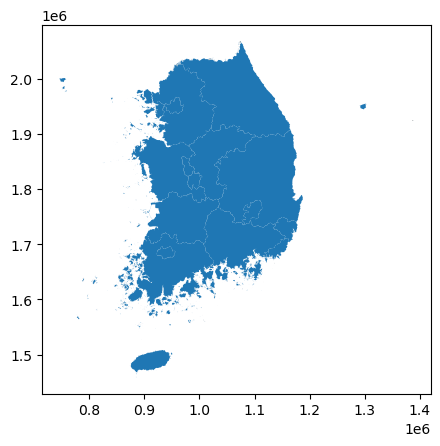

In [25]:
korea.plot()

Text(0.5, 1.0, '2022-12-cori')

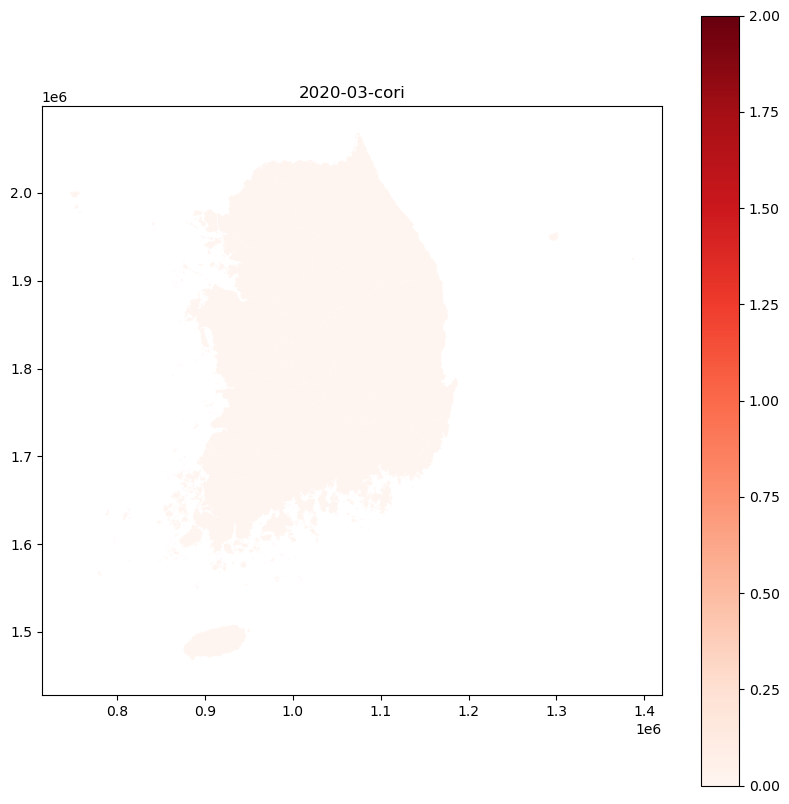

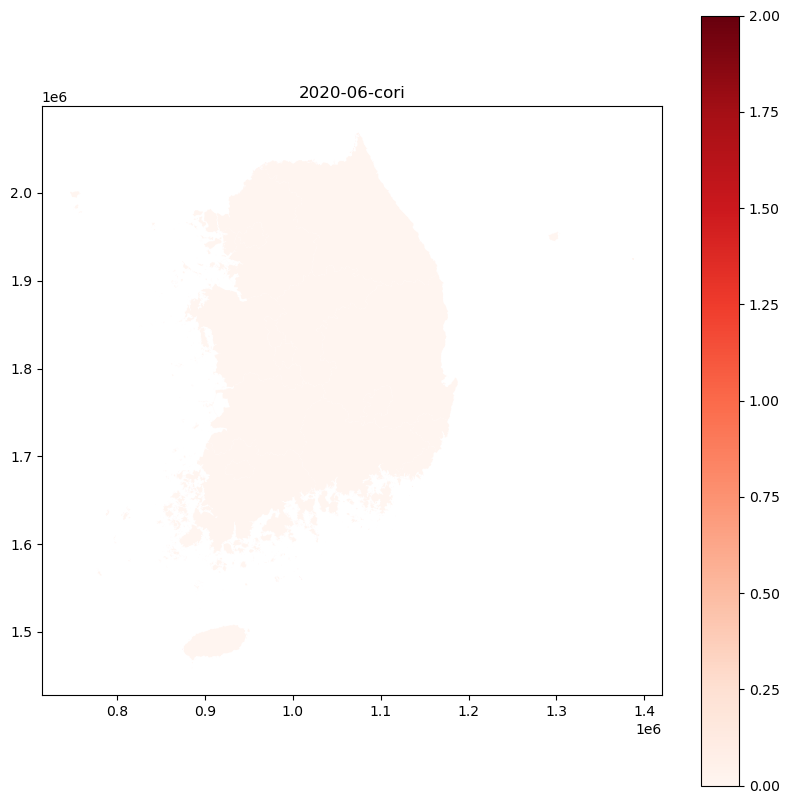

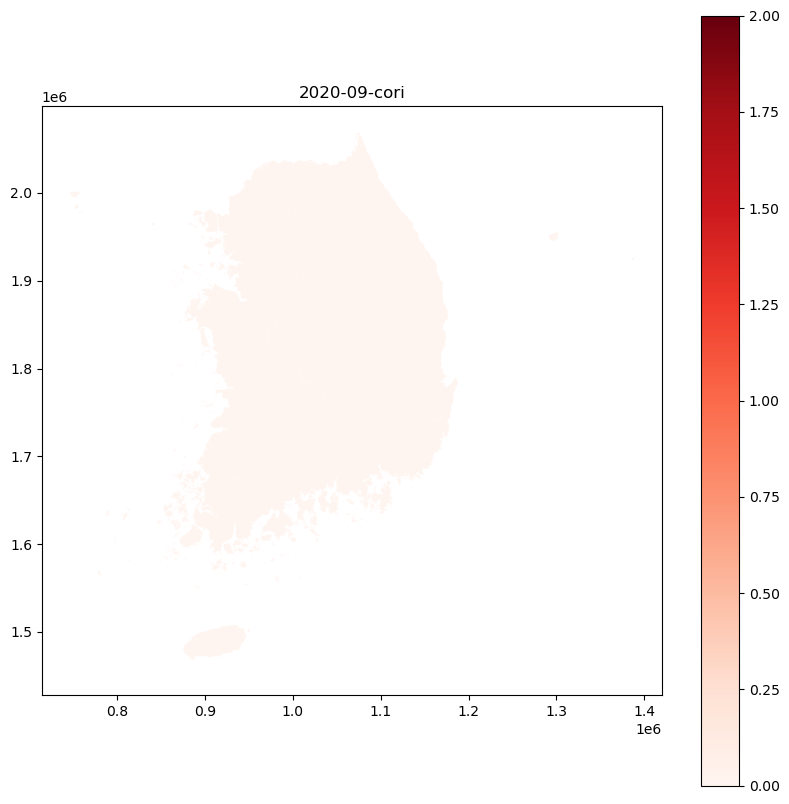

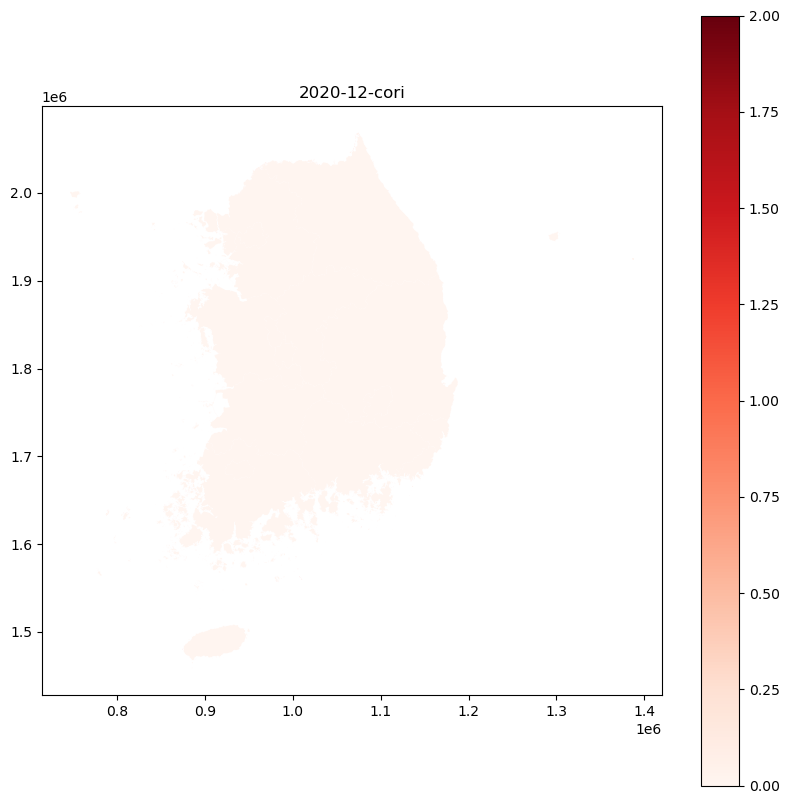

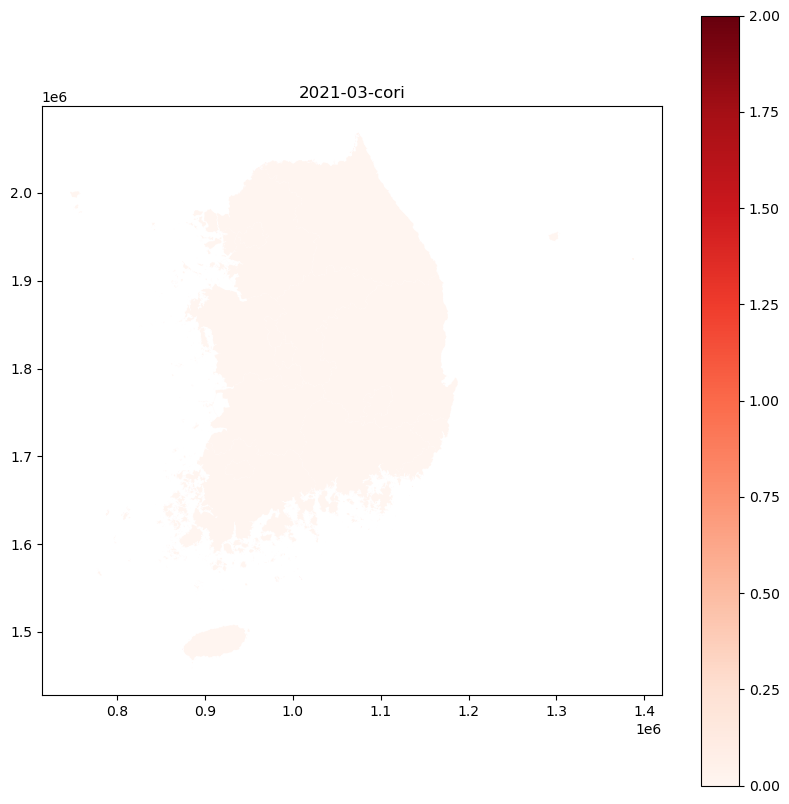

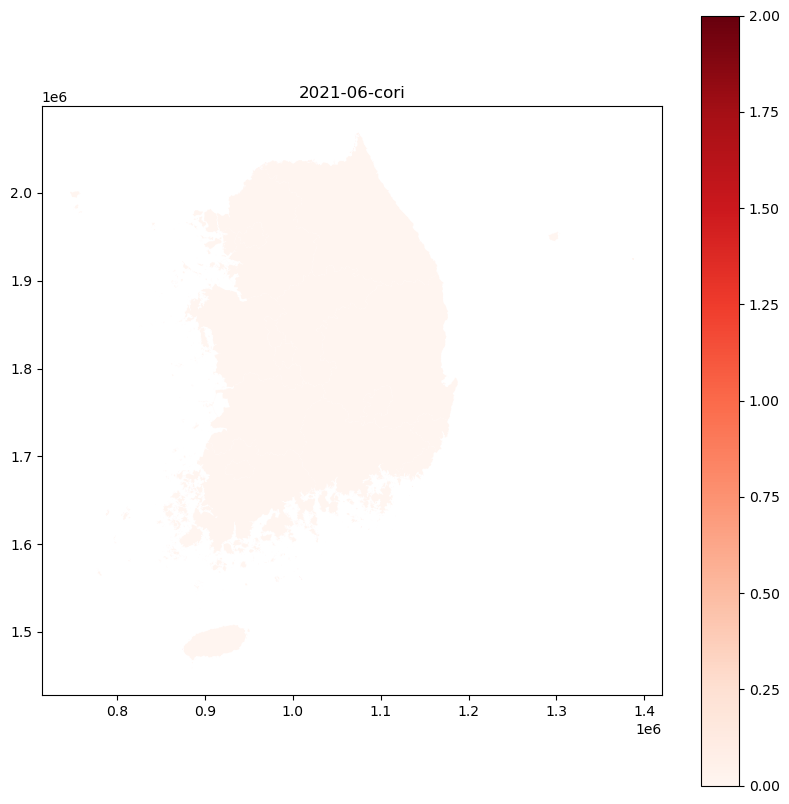

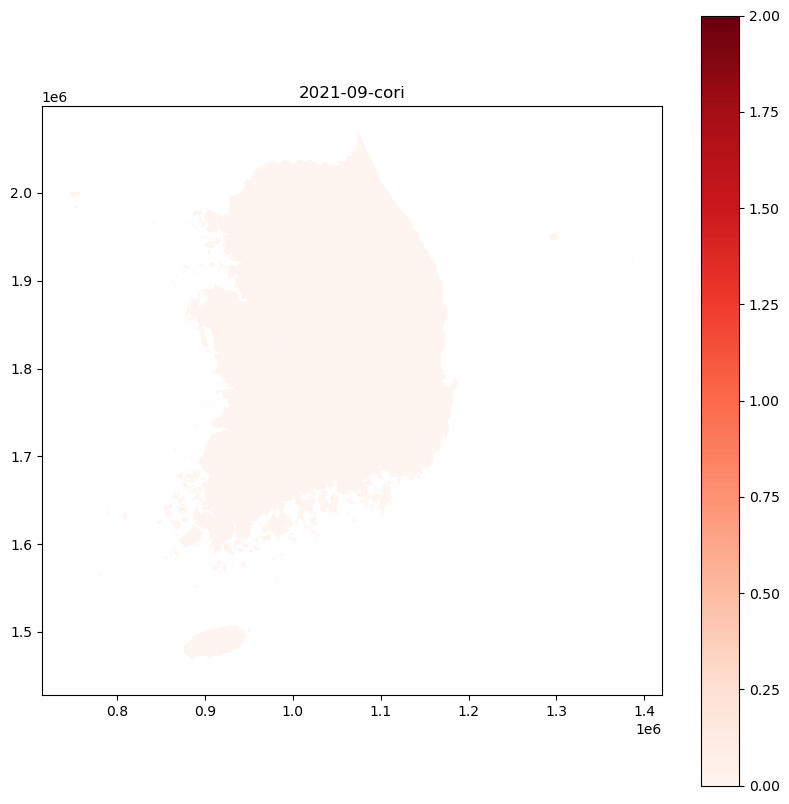

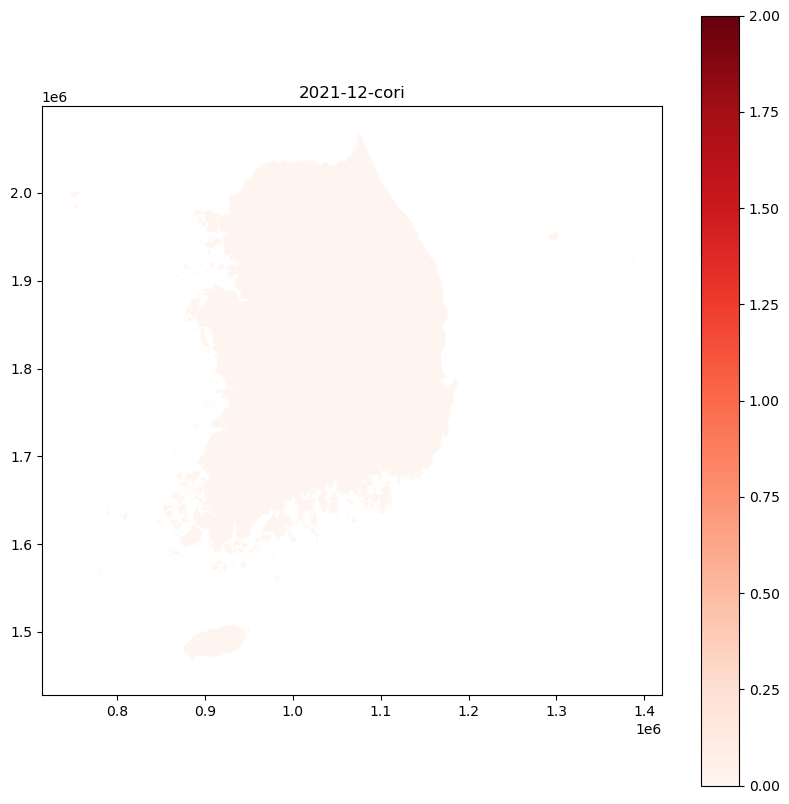

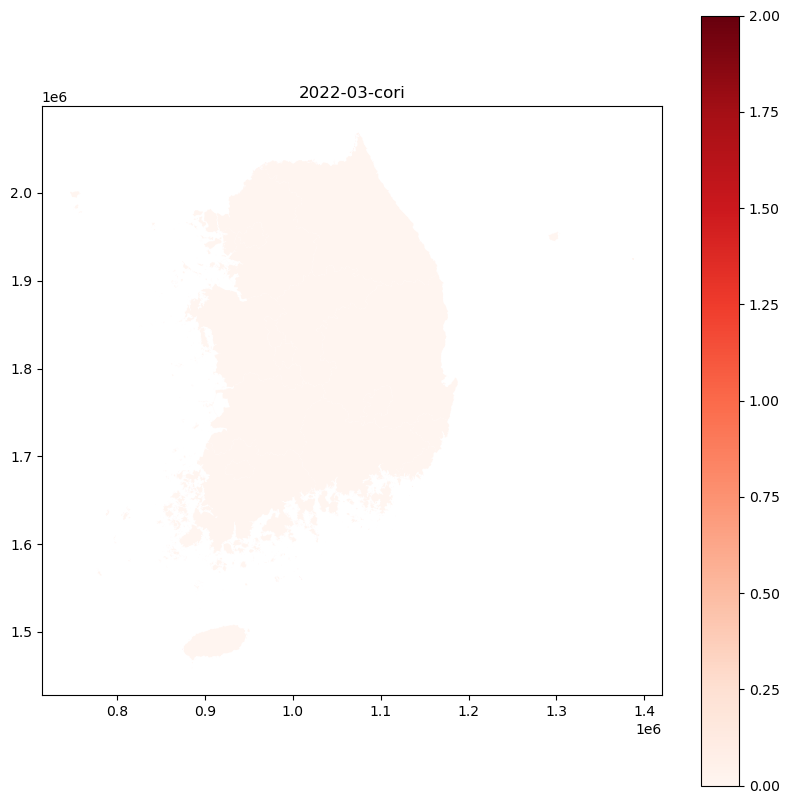

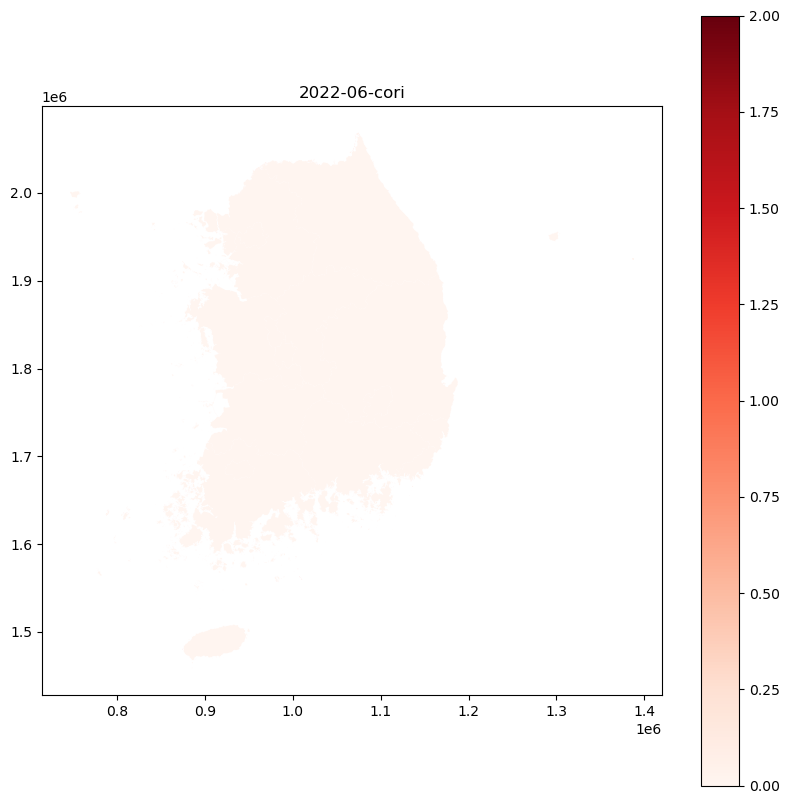

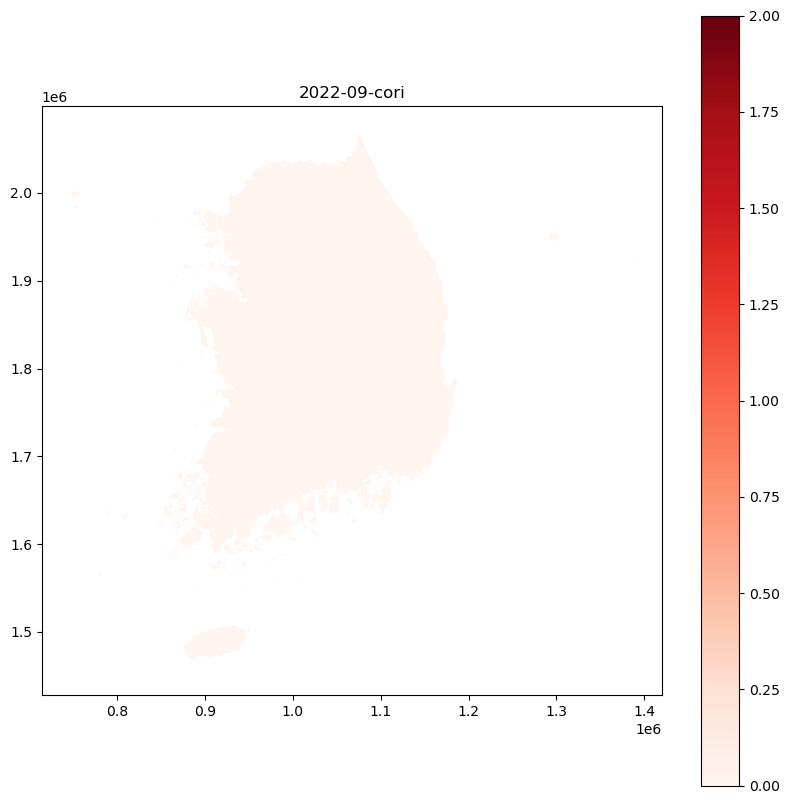

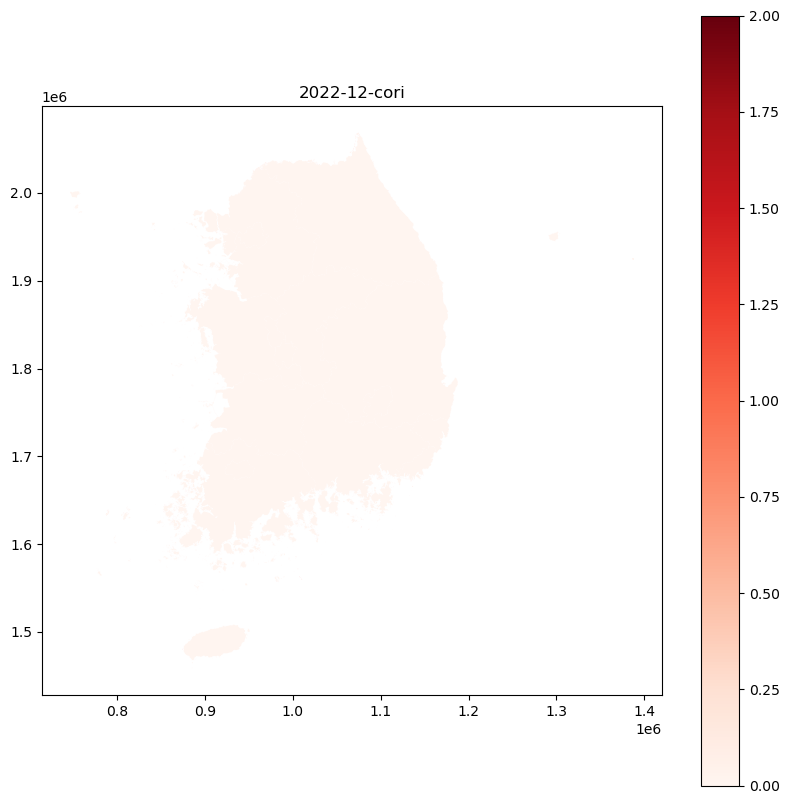

In [82]:
# 전체 확진자, cori 비교

df_202003_cori.plot(column = '2020-03', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2020-03-cori')

df_202006_cori.plot(column = '2020-06', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2020-06-cori')

df_202009_cori.plot(column = '2020-09', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2020-09-cori')

df_202012_cori.plot(column = '2020-12', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2020-12-cori')

df_202103_cori.plot(column = '2021-03', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2021-03-cori')

df_202106_cori.plot(column = '2021-06', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2021-06-cori')

df_202109_cori.plot(column = '2021-09', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2021-09-cori')

df_202112_cori.plot(column = '2021-12', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2021-12-cori')

df_202203_cori.plot(column = '2022-03', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2022-03-cori')

df_202206_cori.plot(column = '2022-06', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2022-06-cori')

df_202209_cori.plot(column = '2022-09', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2022-09-cori')

df_202212_cori.plot(column = '2022-12', cmap = 'Reds', figsize = (10,10), vmin = 0, vmax = 2, legend = True)
plt.title('2022-12-cori')




In [28]:
# 2020년 데이터프레임 생성(지도 히트맵을 위해)
df_202001 = korea.merge(df_result.loc[:,['2020-01']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202002 = korea.merge(df_result.loc[:,['2020-02']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202003 = korea.merge(df_result.loc[:,['2020-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202004 = korea.merge(df_result.loc[:,['2020-04']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202005 = korea.merge(df_result.loc[:,['2020-05']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202006 = korea.merge(df_result.loc[:,['2020-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202007 = korea.merge(df_result.loc[:,['2020-07']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202008 = korea.merge(df_result.loc[:,['2020-08']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202009 = korea.merge(df_result.loc[:,['2020-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202010 = korea.merge(df_result.loc[:,['2020-10']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202011 = korea.merge(df_result.loc[:,['2020-11']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202012 = korea.merge(df_result.loc[:,['2020-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
# 2021년 데이터프레임 생성
df_202101 = korea.merge(df_result.loc[:,['2021-01']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202102 = korea.merge(df_result.loc[:,['2021-02']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202103 = korea.merge(df_result.loc[:,['2021-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202104 = korea.merge(df_result.loc[:,['2021-04']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202105 = korea.merge(df_result.loc[:,['2021-05']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202106 = korea.merge(df_result.loc[:,['2021-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202107 = korea.merge(df_result.loc[:,['2021-07']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202108 = korea.merge(df_result.loc[:,['2021-08']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202109 = korea.merge(df_result.loc[:,['2021-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202110 = korea.merge(df_result.loc[:,['2021-10']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202111 = korea.merge(df_result.loc[:,['2021-11']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202112 = korea.merge(df_result.loc[:,['2021-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
# 2022년 데이터프레임 생성
df_202201 = korea.merge(df_result.loc[:,['2022-01']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')  
df_202202 = korea.merge(df_result.loc[:,['2022-02']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202203 = korea.merge(df_result.loc[:,['2022-03']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202204 = korea.merge(df_result.loc[:,['2022-04']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202205 = korea.merge(df_result.loc[:,['2022-05']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202206 = korea.merge(df_result.loc[:,['2022-06']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202207 = korea.merge(df_result.loc[:,['2022-07']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202208 = korea.merge(df_result.loc[:,['2022-08']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202209 = korea.merge(df_result.loc[:,['2022-09']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202210 = korea.merge(df_result.loc[:,['2022-10']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202211 = korea.merge(df_result.loc[:,['2022-11']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')
df_202212 = korea.merge(df_result.loc[:,['2022-12']], left_on = 'CTP_ENG_NM', right_on = 'city', how = 'left')

In [32]:
for df in df_lst:
    df.columns = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'geometry', 'Cori']

In [33]:
df_lst[1]

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry,Cori
0,11,Seoul,¼­¿ïÆ¯º°½Ã,"POLYGON ((966987.226 1941110.946, 966987.119 1...",1.235161
1,26,Busan,ºÎ»ê±¤¿ª½Ã,"MULTIPOLYGON (((1148194.981 1685460.055, 11481...",1.518654
2,27,Daegu,´ë±¸±¤¿ª½Ã,"POLYGON ((1087859.999 1760097.461, 1087859.951...",1.877092
3,28,Incheon,ÀÎÃµ±¤¿ª½Ã,"MULTIPOLYGON (((847834.755 1881816.658, 847840...",1.305950
4,29,Gwangju,±¤ÁÖ±¤¿ª½Ã,"POLYGON ((932712.687 1696168.692, 932781.680 1...",1.231362
5,30,Daejeon,´ëÀü±¤¿ª½Ã,"POLYGON ((990946.725 1832389.260, 991057.692 1...",1.661343
6,31,Ulsan,¿ï»ê±¤¿ª½Ã,"MULTIPOLYGON (((1167949.952 1710285.043, 11679...",0.000000
7,36,Sejong,¼¼Á¾Æ¯º°ÀÚÄ¡½Ã,"POLYGON ((971235.936 1844386.985, 971234.055 1...",0.797516
8,41,Gyeonggi,°æ±âµµ,"MULTIPOLYGON (((931607.470 1894480.382, 931653...",1.441892
9,42,Gangwon,°­¿øµµ,"MULTIPOLYGON (((1163759.191 1909653.101, 11637...",0.423976


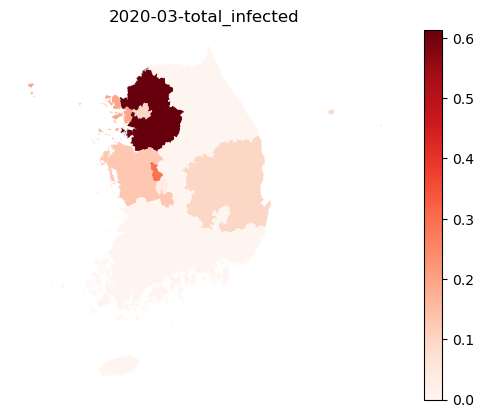

<function matplotlib.pyplot.show(close=None, block=None)>

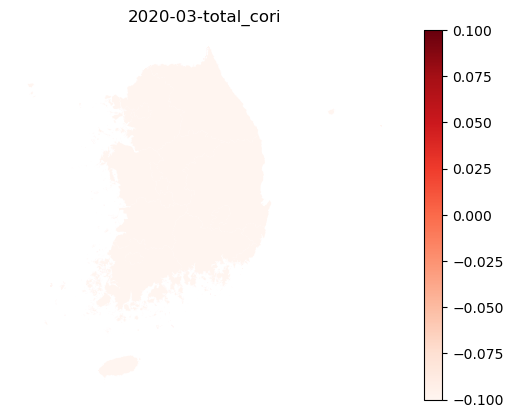

In [76]:

df_202003_total.plot(column = '2020-03', cmap = 'Reds', legend = True)
plt.axis('off')
plt.title('2020-03-total_infected')
plt.show()

df_202003_cori.plot(column = '2020-03', cmap = 'Reds', legend = True)
plt.axis('off')
plt.title('2020-03-total_cori')
plt.show

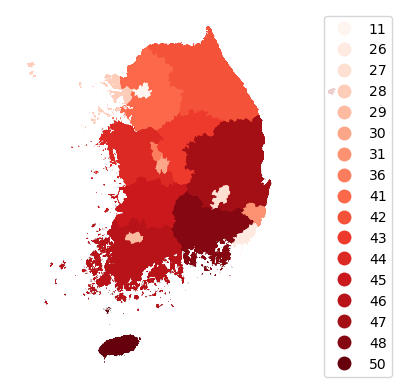

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')
def animate(t = 4):
    for df in df_lst:
        df.plot(column = df[df.columns[t]], cmap = 'Reds', legend = True, ax = ax)
        
from matplotlib.animation import FuncAnimation        
anim = FuncAnimation(fig, animate, interval = 5)

In [42]:
df.columns

Index(['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'geometry', 'Cori'], dtype='object')

AttributeError: 'list' object has no attribute 'to_csv'